In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date
import calendar
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_excel('Traffic.xlsx')

df['Start Time'] = pd.to_datetime(df['Start Time'])
df.set_index('Start Time',drop=False,inplace=True)
df['DL RBLER (%)']=df['DL RBLER (%)'].replace('NIL',np.nan)
df['DL RBLER (%)']=df['DL RBLER (%)'].astype(float)
df['DL RBLER (%)'].fillna(df['DL RBLER (%)'].median(),inplace=True)
df['DL user tput']=df['L.Thrp.bits.DL.QCI.9 (bit)']/(df['L.Thrp.Time.DL.QCI.9 (ms)']*1000)
df['DL cell tput']=df['L.Thrp.bits.DL (bit)']/(df['L.Thrp.Time.Cell.DL (s)']*1000000)

df['DL user tput']=df['DL user tput'].replace(np.nan,0)
df['DL cell tput']=df['DL cell tput'].replace(np.nan,0)

In [27]:
mean_users=df[['Cell','L.Traffic.User.Avg (None)']].groupby('Cell').mean().reset_index()
mean_users.sort_values('L.Traffic.User.Avg (None)', ascending=False).head(20)

,Cell,L.Traffic.User.Avg (None)
72,"Local cell identity=0, Cell Name=eNB_3410-0",117.693921
261,"Local cell identity=2, Cell Name=eNB_3167-2",116.084293
307,"Local cell identity=2, Cell Name=eNB_3525-2",115.423359
3,"Local cell identity=0, Cell Name=eNB_2151-0",112.719250
294,"Local cell identity=2, Cell Name=eNB_3401-2",109.757517
147,"Local cell identity=1, Cell Name=eNB_3167-1",109.051091
36,"Local cell identity=0, Cell Name=eNB_3167-0",101.343831
160,"Local cell identity=1, Cell Name=eNB_3186-1",98.310755
86,"Local cell identity=0, Cell Name=eNB_3808-0",90.664240
189,"Local cell identity=1, Cell Name=eNB_3524-1",88.575326


In [21]:
df_filter=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_3525-2']

df_filter=df_filter.drop('Cell',axis=1)

df_filter.index.freq='15T'
df_filter.index

DatetimeIndex(['2013-08-28 00:00:00', '2013-08-28 00:15:00',
               '2013-08-28 00:30:00', '2013-08-28 00:45:00',
               '2013-08-28 01:00:00', '2013-08-28 01:15:00',
               '2013-08-28 01:30:00', '2013-08-28 01:45:00',
               '2013-08-28 02:00:00', '2013-08-28 02:15:00',
               ...
               '2013-09-04 21:30:00', '2013-09-04 21:45:00',
               '2013-09-04 22:00:00', '2013-09-04 22:15:00',
               '2013-09-04 22:30:00', '2013-09-04 22:45:00',
               '2013-09-04 23:00:00', '2013-09-04 23:15:00',
               '2013-09-04 23:30:00', '2013-09-04 23:45:00'],
              dtype='datetime64[ns]', name='Start Time', length=768, freq='15T')

In [19]:
df_filter

,Start Time,L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None),L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None),L.Traffic.UL.SCH.QPSK.TB (None),L.Traffic.UL.SCH.QPSK.TB.bits (bit),L.Traffic.UL.SCH.QPSK.TB.Retrans (None),L.Traffic.UL.SCH.QPSK.TB.Retrans.bits (bit),L.Traffic.DL.PktDelay.Num.QCI.9 (packet),L.Traffic.DL.PktDelay.Time.QCI.9 (ms),L.Traffic.DL.PktUuLoss.Loss.QCI.9 (packet),...,L.Traffic.UL.SCH.16QAM.TB.Retrans (None),L.Traffic.UL.SCH.16QAM.TB.Retrans.bits (bit),L.Traffic.UL.SCH.64QAM.ErrTB.Ibler (None),L.Traffic.UL.SCH.64QAM.ErrTB.Rbler (None),L.Traffic.UL.SCH.64QAM.TB (None),L.Traffic.UL.SCH.64QAM.TB.bits (bit),L.Traffic.UL.SCH.64QAM.TB.Retrans (None),L.Traffic.UL.SCH.64QAM.TB.Retrans.bits (bit),DL user tput,DL cell tput
Start Time,,,,,,,,,,,,,,,,,,,,,
2013-08-28 00:00:00,2013-08-28 00:00:00,24330,1333,238979,185776536,31921,20417368,1259038,707299373,1686,...,50239,90627320,0,0,0,0,0,0,0.296465,11.953862
2013-08-28 00:15:00,2013-08-28 00:15:00,25293,1860,236767,192248304,34958,21157496,1322946,746134907,1620,...,53500,94569088,0,0,0,0,0,0,0.361509,12.657126
2013-08-28 00:30:00,2013-08-28 00:30:00,21440,1557,202912,157953520,29440,18513320,1276586,726327028,2150,...,53835,79792424,0,0,0,0,0,0,0.356419,12.213833
2013-08-28 00:45:00,2013-08-28 00:45:00,21372,1576,185831,139333776,31451,17416288,1280050,737246403,1573,...,51280,74672120,0,0,0,0,0,0,0.370754,12.195893
2013-08-28 01:00:00,2013-08-28 01:00:00,24618,4760,207515,137084280,46276,16782408,1228189,707942443,2185,...,49980,77287664,0,0,0,0,0,0,0.289575,11.779891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-04 22:45:00,2013-09-04 22:45:00,21556,1729,209140,161940272,29991,19091360,1328801,656314229,2196,...,47065,79510096,0,0,0,0,0,0,0.333828,11.411952
2013-09-04 23:00:00,2013-09-04 23:00:00,20122,1533,191802,153943880,27583,17195624,1212699,535834876,3832,...,41682,74718760,0,0,0,0,0,0,0.270513,9.411965
2013-09-04 23:15:00,2013-09-04 23:15:00,23724,2198,218018,163934136,33622,18486280,1197299,575426881,2619,...,45898,83040912,0,0,0,0,0,0,0.289410,10.174141


In [ ]:
sns.regplot(cluster_merge['L.Traffic.User.Avg (None)'],cluster_merge['DL cell tput'])

In [ ]:
mean_users=df[['Cell','L.Traffic.User.Avg (None)']].groupby('Cell').mean().reset_index()
mean_users.sort_values('L.Traffic.User.Avg (None)', ascending=False)

In [328]:
df_filter=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_3404-2']

df_filter=df_filter.drop('Cell',axis=1)

df_filter.index.freq='15T'
df_filter.index

DatetimeIndex(['2013-08-28 00:00:00', '2013-08-28 00:15:00',
               '2013-08-28 00:30:00', '2013-08-28 00:45:00',
               '2013-08-28 01:00:00', '2013-08-28 01:15:00',
               '2013-08-28 01:30:00', '2013-08-28 01:45:00',
               '2013-08-28 02:00:00', '2013-08-28 02:15:00',
               ...
               '2013-09-04 21:30:00', '2013-09-04 21:45:00',
               '2013-09-04 22:00:00', '2013-09-04 22:15:00',
               '2013-09-04 22:30:00', '2013-09-04 22:45:00',
               '2013-09-04 23:00:00', '2013-09-04 23:15:00',
               '2013-09-04 23:30:00', '2013-09-04 23:45:00'],
              dtype='datetime64[ns]', name='Start Time', length=768, freq='15T')

In [ ]:
#list(df_filter.dtypes)

obj_cols = []
for col in df_filter.columns:
    if df_filter[col].dtypes == 'object':
        obj_cols.append(col)
        
obj_cols

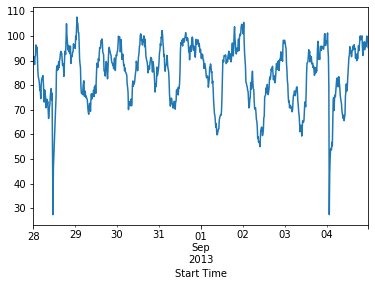

In [195]:
df_filter['L.Traffic.User.Avg (None)'].plot()

#df_filter['DL user tput'].plot()

#sns.distplot(np.log(df_filter['DL user tput']))
#np.log(df_filter['DL user tput']).plot()

In [133]:
np.corrcoef(df_filter['DL user tput'],df_filter['L.Traffic.DL.PktUuLoss.Tot.QCI.9 (packet)'])[1][0]

#sns.regplot(df_filter['DL user tput'],df_filter['L.Traffic.UL.PktLoss.Tot.QCI.9 (packet)'])

-0.4976434034045515

-0.7946642123967669

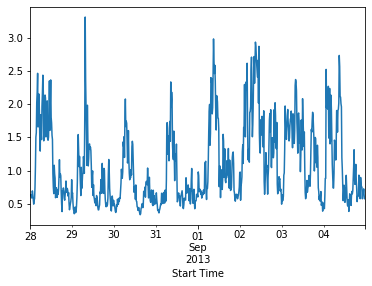

In [196]:
df_filter['DL user tput'].plot()

np.corrcoef(df_filter['DL user tput'],df_filter['L.Traffic.User.Avg (None)'])[1][0]

In [96]:
#sns.pairplot(df_filter)


corrMatrix = df_filter.corr()
#plt.matshow(corrMatrix)
#print (corrMatrix)

In [97]:
drop_columns=list(corrMatrix['DL user tput'][abs(corrMatrix['DL user tput'])<0.65].index)
drop_columns

['L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None)',
 'L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None)',
 'L.Traffic.UL.SCH.QPSK.TB (None)',
 'L.Traffic.UL.SCH.QPSK.TB.bits (bit)',
 'L.Traffic.UL.SCH.QPSK.TB.Retrans (None)',
 'L.Traffic.UL.SCH.QPSK.TB.Retrans.bits (bit)',
 'L.Traffic.DL.PktDelay.Num.QCI.9 (packet)',
 'L.Traffic.DL.PktDelay.Time.QCI.9 (ms)',
 'L.Traffic.DL.PktUuLoss.Loss.QCI.9 (packet)',
 'L.Traffic.DL.PktUuLoss.Tot.QCI.9 (packet)',
 'L.Traffic.UL.PktLoss.Loss.QCI.9 (packet)',
 'L.Traffic.UL.PktLoss.Tot.QCI.9 (packet)',
 'DL RBLER (%)',
 'L.PDCP.Tx.TotRev.Trf.SDU.QCI.9 (packet)',
 'L.Thrp.bits.DL (bit)',
 'L.Thrp.bits.DL.Max (bit)',
 'L.Thrp.bits.DL.QCI.9 (bit)',
 'L.Thrp.bits.DL.QCI.9.Max (bit)',
 'L.Thrp.bits.DL.SRB (bit)',
 'L.Thrp.bits.UL (bit)',
 'L.Thrp.bits.UL.Max (bit)',
 'L.Thrp.bits.UL.QCI.9 (bit)',
 'L.Thrp.bits.UL.SRB (bit)',
 'L.Thrp.bits.UL.QCI.9.Max (bit)',
 'L.Thrp.Time.Cell.DL (s)',
 'L.Thrp.Time.Cell.UL (s)',
 'L.Thrp.Time.UL (ms)',
 'L.Thrp.Time.UL.QCI.9 (ms)',
 'L.

In [98]:
df_filter=df_filter.drop(drop_columns,axis=1)

In [ ]:
alpha=0.3
ses=SimpleExpSmoothing(df_filter['DL user tput'],initialization_method='legacy-heuristic')

In [ ]:
res=ses.fit(smoothing_level=alpha,optimized=False)

In [ ]:
df_filter['SES']=res.predict(start=df_filter.index[0],end=df_filter.index[-1])

In [ ]:
df_filter['SES']

In [ ]:
df_filter[['DL user tput','SES']].plot()

In [323]:
df_filter.drop(df_filter.tail(9).index,
        inplace = True)

Ntest=96
train=df_filter.iloc[:-Ntest]
test=df_filter.iloc[-Ntest:]


train_idx=df_filter.index <= train.index[-1]
test_idx=df_filter.index > train.index[-1]

In [169]:
train['DL user tput']=train['DL user tput']+0.1
test['DL user tput']=test['DL user tput']+0.1

In [ ]:
ses=SimpleExpSmoothing(train['DL user tput'],initialization_method='legacy-heuristic')
res=ses.fit()

In [82]:
test

,Start Time,L.Traffic.DL.PktDelay.Time.QCI.9 (ms),L.PDCP.DL.RoHC.HdrCompRatio (%),L.PDCP.DL.RoHC.PktCompRatio (%),L.PDCP.Tx.Disc.Trf.SDU.QCI.9 (packet),L.PDCP.UL.RoHC.FailDecompRatio (%),L.Traffic.CEU.Avg (None),L.Traffic.User.ULData.Avg (None),L.Traffic.User.DLData.Avg (None),L.Traffic.CEU.Max (None),...,L.E-RAB.SessionTime.UE (s),L.Thrp.Time.DL (ms),L.Thrp.Time.DL.QCI.9 (ms),L.Traffic.UL.SCH.64QAM.ErrTB.Ibler (None),L.Traffic.UL.SCH.64QAM.ErrTB.Rbler (None),L.Traffic.UL.SCH.64QAM.TB (None),L.Traffic.UL.SCH.64QAM.TB.bits (bit),L.Traffic.UL.SCH.64QAM.TB.Retrans (None),L.Traffic.UL.SCH.64QAM.TB.Retrans.bits (bit),DL user tput
Start Time,,,,,,,,,,,,,,,,,,,,,
2013-09-04 00:00:00,2013-09-04 00:00:00,427659573,0,0,23826,0,0,48.239,50.298,0,...,43423,13435063,13435063,0,0,0,0,0,0,0.684853
2013-09-04 00:15:00,2013-09-04 00:15:00,485677783,0,0,27774,0,0,48.974,51.340,0,...,44092,15406098,15406098,0,0,0,0,0,0,0.606191
2013-09-04 00:30:00,2013-09-04 00:30:00,436019377,0,0,21573,0,0,48.864,50.920,0,...,43982,14974602,14974602,0,0,0,0,0,0,0.635798
2013-09-04 00:45:00,2013-09-04 00:45:00,419462129,0,0,16943,0,0,45.400,47.386,0,...,40875,12638622,12638622,0,0,0,0,0,0,0.813310
2013-09-04 01:00:00,2013-09-04 01:00:00,306687427,0,0,13621,0,0,42.317,44.620,0,...,38084,9912522,9912522,0,0,0,0,0,0,0.894650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-04 22:45:00,2013-09-04 22:45:00,449771593,0,0,28130,0,0,44.947,46.594,0,...,40456,11169559,11169559,0,0,0,0,0,0,0.830111
2013-09-04 23:00:00,2013-09-04 23:00:00,565611223,0,0,39100,0,0,50.220,51.193,0,...,45190,15484343,15484343,0,0,0,0,0,0,0.584328
2013-09-04 23:15:00,2013-09-04 23:15:00,528539009,0,0,33620,0,0,51.030,52.149,0,...,45926,13981519,13981519,0,0,0,0,0,0,0.641623


In [ ]:
df_filter.loc[train_idx,'SESfitted']=res.fittedvalues
df_filter.loc[test_idx,'SESfitted']=res.forecast(Ntest)
df_filter[['DL user tput','SESfitted']].plot()

In [83]:
holt=Holt(train['DL user tput'],initialization_method='legacy-heuristic')
res_h=holt.fit()

In [84]:
df_filter.loc[train_idx,'Holt']=res_h.fittedvalues
df_filter.loc[test_idx,'Holt']=res_h.forecast(Ntest)

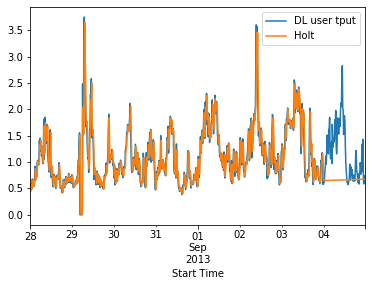

In [85]:
df_filter[['DL user tput','Holt']].plot()

In [324]:
HW=ExponentialSmoothing((train['DL user tput']),initialization_method='estimated',damped_trend=False,trend='add',seasonal='mul',use_boxcox=False,seasonal_periods=96)
res_hw=HW.fit()

In [ ]:
best score: 0.3813889915557326
trend_type add
seasonal_type mul
damped_trend False
init_method estimated
use_boxcox False


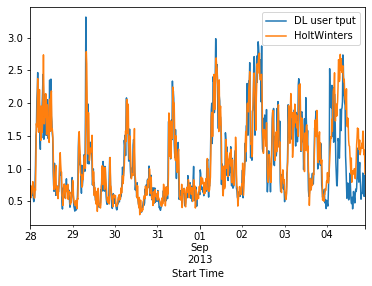

In [325]:
df_filter.loc[train_idx,'HoltWinters']=(res_hw.fittedvalues)
df_filter.loc[test_idx,'HoltWinters']=(res_hw.forecast(Ntest))
#df_filter['HoltWinters']=np.sqrt(df_filter['HoltWinters'])
df_filter[['DL user tput','HoltWinters']].plot()

In [326]:
test['HW']=(res_hw.forecast(Ntest))

-0.10295712062802265

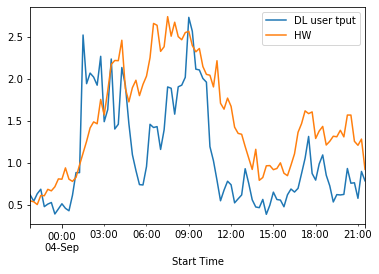

In [327]:
test[['DL user tput','HW']].plot()
r2_score(test['DL user tput'],test['HW'])

In [ ]:
df_filter['DL user tput'].iloc[-Ntest:].min()

In [120]:
mean_squared_error(test['DL user tput'],test['HW'])

0.17691475566850523

In [238]:
h=96
steps=10
Ntest=len(df_filter)-96-steps+1

In [214]:
def walkforward(trend_type,seasonal_type,damped_trend,init_method,use_boxcox,debug=False):
    errors=[]
    seen_last=False
    steps_completed=0
    
    for end_of_train in range(Ntest, len(df)-h+1):
        train=df_filter.iloc[:end_of_train]
        test=df_filter.iloc[end_of_train:end_of_train+h]
        
        if test.index[-1]==df_filter.index[-1]:
            seen_last=True
            
        steps_completed +=1
        
        hw=ExponentialSmoothing(
        train['DL user tput'],
        initialization_method=init_method,
        trend=trend_type,
        damped_trend=damped_trend,
        seasonal=seasonal_type,
        seasonal_periods=96,
        use_boxcox=use_boxcox)
        res_hw=hw.fit()
        
        fcast=res_hw.forecast(h)
        error=mean_squared_error(test['DL user tput'],fcast)
        #error=r2_score(test['DL user tput'],fcast)
        errors.append(error)
        
        if debug:
            print("seen last:",seen_last)
            print("steps completed:",steps_completed)
            
        return np.mean(errors)
    
    

In [284]:
trend_type_list=['add']
seasonal_type_list=['add','mul']
damped_trend_list=[True,False]
init_method_list=['estimated','heuristic','legacy-heuristic']
use_boxcox_list=[True,False,0]

tupe_of_option_lists=(
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list,
    use_boxcox_list   

)

In [218]:
best_score=float('inf')
best_options=None
for x in itertools.product(*tupe_of_option_lists):
    score=walkforward(*x)
    
    if score < best_score:
        print("Best score so far:",score)
        best_score=score
        best_options=x

Best score so far: 0.18177083494090152
Best score so far: 0.34731765334056963
Best score so far: 0.34762606052510925
Best score so far: 0.3514377618663548
Best score so far: 0.35159678331847255
Best score so far: 0.5485554648564585


In [318]:
print("best score:",best_score)

trend_type,seasonal_type,damped_trend,init_method,use_boxcox=best_options
print("trend_type",trend_type)
print("seasonal_type",seasonal_type)
print("damped_trend",damped_trend)
print("init_method",init_method)
print("use_boxcox",use_boxcox)

best score: 0.3813889915557326
trend_type add
seasonal_type mul
damped_trend False
init_method estimated
use_boxcox False


In [299]:
h=96
steps=10
Ntest=len(df_filter)-96-steps+1

trend_type_list=['add']
seasonal_type_list=['add','mul']
damped_trend_list=[True,False]
init_method_list=['estimated','heuristic','legacy-heuristic']
use_boxcox_list=[False,0]

tupe_of_option_lists=(
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list,
    use_boxcox_list   

)

In [308]:
def walkforward(trend_type,seasonal_type,damped_trend,init_method,use_boxcox,debug=False):
    errors=[]
    seen_last=False
    steps_completed=0
    
    for end_of_train in range(Ntest, len(df_filter)-h+1):
        train=df_filter.iloc[:end_of_train]
        train.fillna(train.mean(), inplace = True)
        test=df_filter.iloc[end_of_train:end_of_train+h]
        test.fillna(test.mean(), inplace = True)
        
        if test.index[-1]==df_filter.index[-1]:
            seen_last=True
            
        steps_completed +=1
        
        print(trend_type,seasonal_type,damped_trend,init_method,use_boxcox)
        
        hw=ExponentialSmoothing(
        train['DL user tput'],
        initialization_method=init_method,
        trend=trend_type,
        damped_trend=damped_trend,
        seasonal=seasonal_type,
        seasonal_periods=96,
        use_boxcox=use_boxcox)
        res_hw=hw.fit()
        
        fcast=res_hw.forecast(h)
        #error=mean_squared_error(test['DL user tput'],fcast)
        error=r2_score(test['DL user tput'],fcast)
        errors.append(error)
        
        if debug:
            print("seen last:",seen_last)
            print("steps completed:",steps_completed)
            
    return errors
    
    

In [316]:
best_score=float(0)
best_options=None




for x in itertools.product(*tupe_of_option_lists):
    score=walkforward(*x)
    
    if score[9] > best_score:
        print("Best score so far:",score)
        best_score=score[9]
        print(best_score)
        best_options=x

add add True estimated False
add add True estimated False
add add True estimated False
add add True estimated False
add add True estimated False
add add True estimated False
add add True estimated False
add add True estimated False
add add True estimated False
add add True estimated False
Best score so far: [0.34731765334056963, 0.3757222763815997, 0.36968554296425415, 0.3732538700855744, 0.3703757886667828, 0.36512338466056904, 0.33788707228613823, 0.35035893566858, 0.2697836182766462, 0.24157722319734076]
0.24157722319734076
add add True estimated 0
add add True estimated 0
add add True estimated 0
add add True estimated 0
add add True estimated 0
add add True estimated 0
add add True estimated 0
add add True estimated 0
add add True estimated 0
add add True estimated 0
add add True heuristic False
add add True heuristic False
add add True heuristic False
add add True heuristic False
add add True heuristic False
add add True heuristic False
add add True heuristic False
add add True h